# 3 эксперимента рекомендательной системы

**Проект:** Рекомендательная система для e-commerce

## Цель
Провести 3 эксперимента, демонстрирующих прогресс развития модели:
1. **Baseline** - простейший baseline (Popular Items)
2. **Промежуточный** - ALS с оптимизированными весами событий (WEIGHTS_v1.0_a4.0_t8.0)
3. **Финальный** - ALS с весами + Content-Based Re-ranking (WEIGHTS_RERANK_a0.6_b0.4)

## Выводы из EDA
На основе анализа данных (`eda_processing.py`):
- **Разреженность:** 99.9992% - экстремально высокая
- **Активность пользователей:** Медиана = 1.0 событие на пользователя
- **Распределение событий:** 96.67% views, 2.52% addtocart, 0.81% transaction
- **Покрытие категориями:** 78.81% товаров имеют категории
- **Выводы:** Необходимы правильные веса событий, обязательный fallback для cold users, использование категорий для content-based подходов

## Пайплайн обработки данных и построения модели

Полный пайплайн включает следующие этапы:
1. **Загрузка данных** - события пользователей, метаданные товаров, категории
2. **Построение interactions** - преобразование событий в взаимодействия с весами
3. **Temporal split** - разделение на train/test по времени (15% test)
4. **Построение user-item матрицы** - создание sparse матрицы для ALS
5. **Обучение ALS модели** - collaborative filtering
6. **Генерация рекомендаций** - с fallback для cold users
7. **Content-Based Re-ranking** - улучшение рекомендаций на основе категорий
8. **Оценка метрик** - вычисление Recall@20, Precision@5, NDCG@10, Hit Rate@5
9. **Сохранение модели** - сохранение в bin-файл для продакшена

In [1]:
# Импорты
import sys
import os
import logging
import datetime
import gc
from pathlib import Path

# Определяем корень проекта и добавляем его в PYTHONPATH
try:
    # Для .py файла используем __file__
    notebook_dir = Path(__file__).parent
except NameError:
    # Для Jupyter notebook используем текущую рабочую директорию
    notebook_dir = Path.cwd()
    # Если запущено из notebooks/, берем родителя
    if notebook_dir.name == "notebooks":
        project_root = notebook_dir.parent
    else:
        # Если запущено из корня проекта
        project_root = notebook_dir
else:
    project_root = notebook_dir.parent if notebook_dir.name == "notebooks" else notebook_dir

# Добавляем корень проекта в PYTHONPATH (не src, а родительскую директорию src!)
# Это необходимо, чтобы импорты вида "from src.recsys.data.events import load_events" работали
project_root = project_root.resolve()
if (project_root / "src").exists():
    sys.path.insert(0, str(project_root))
else:
    raise RuntimeError(f"Директория src не найдена в проекте: {project_root / 'src'}")

import polars as pl
import numpy as np

from src.recsys.data.events import load_events
from src.recsys.preprocess.interactions import InteractionConfig, build_interactions
from src.recsys.split import temporal_split_per_user
from src.recsys.matrix import build_user_item_matrix
from src.recsys.models.als import train_als
from src.recsys.models.popular import top_popular_items, top_popular_items_by_cart
from src.recsys.models.recommendations import generate_recommendations
from src.recsys.models.rerank import category_based_rerank
from src.recsys.evaluation.metrics import (
    compute_all_metrics,
    precision_recall_ndcg_at_k,
    hit_rate_at_k,
    coverage_at_k,
    novelty_at_k,
    diversity_at_k,
    cart_prediction_rate,
)
from src.recsys.artifacts import (
    get_item_metadata,
    get_category_stats,
    get_category_tree_enhanced,
    clear_artifact_cache,
    save_artifacts,
)
from src.recsys.utils.logging import get_log_file_path, configure_polars_logging

# Настройка логирования
log_level = os.getenv("PROCESSING_LOG_LEVEL", "INFO").upper()

# Путь к директории логов
try:
    script_dir = Path(__file__).parent
except NameError:
    script_dir = Path.cwd()

project_root = script_dir.parent if script_dir.name == "notebooks" else script_dir
logs_dir = project_root / "logs"
logs_dir.mkdir(exist_ok=True)

# Создаём единый timestamp для всего запуска
run_timestamp = datetime.datetime.now()
log_file_path = get_log_file_path("experiments_processing", logs_dir, run_timestamp)

# Настройка логирования
logger = logging.getLogger(__name__)
logger.setLevel(getattr(logging, log_level, logging.INFO))

if not logger.handlers:
    formatter = logging.Formatter(
        "%(asctime)s - %(levelname)s - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    )
    
    # Handler для консоли
    console_handler = logging.StreamHandler()
    console_handler.setLevel(getattr(logging, log_level, logging.INFO))
    console_handler.setFormatter(formatter)
    
    # Handler для файла
    file_handler = logging.FileHandler(log_file_path, encoding="utf-8")
    file_handler.setLevel(logging.DEBUG)
    file_handler.setFormatter(formatter)
    
    logger.addHandler(console_handler)
    logger.addHandler(file_handler)

logger.propagate = False

# Настройка Polars
configure_polars_logging()

# Путь к данным
data_dir = project_root / "data" / "raw"
artifacts_dir = project_root / "artifacts"

logger.info(f"Время запуска: {run_timestamp}")
logger.info(f"Лог файл: {log_file_path}")

2025-12-21 17:28:17 - INFO - Время запуска: 2025-12-21 17:28:17.783535
2025-12-21 17:28:17 - INFO - Лог файл: /home/mle-user/mle-pr-final/logs/experiments_processing_2025-12-21_17-28-17.log


## 1. Загрузка данных и подготовка

In [2]:
# Очищаем кэш артефактов для загрузки свежих данных
clear_artifact_cache()

# Проверка наличия артефактов и их создание при необходимости
from src.recsys.scripts.create_artifacts import create_artifacts

artifacts_exist = all(
    (artifacts_dir / f"{name}.parquet").exists()
    for name in ["item_metadata", "category_stats", "category_tree", "item_availability", "item_popularity"]
)

if not artifacts_exist:
    logger.info("Артефакты не найдены, создание артефактов из сырых данных...")
    create_artifacts(
        project_root=project_root,
        data_dir=data_dir,
        artifacts_dir=artifacts_dir,
        logger=logger,
    )
    logger.info("Артефакты созданы, очищаем кэш для загрузки новых данных")
    clear_artifact_cache()
else:
    logger.info("Артефакты уже существуют, используем существующие")

# Загрузка событий
logger.info("Загрузка данных...")
events = load_events(data_dir)
logger.info(f"Загружено событий: {len(events):,}")

# Загрузка артефактов
item_metadata = get_item_metadata(project_root)
category_stats = get_category_stats(project_root)
category_tree = get_category_tree_enhanced(project_root)
logger.info(f"Загружено метаданных товаров: {len(item_metadata):,}")
logger.info(f"Загружено статистики категорий: {len(category_stats):,}")
logger.info(f"Загружено дерева категорий: {len(category_tree):,}")

2025-12-21 17:28:17 - INFO - Артефакты уже существуют, используем существующие
2025-12-21 17:28:17 - INFO - Загрузка данных...
2025-12-21 17:28:18 - INFO - Загружено событий: 2,756,101
2025-12-21 17:28:18 - INFO - Загружено метаданных товаров: 417,052
2025-12-21 17:28:18 - INFO - Загружено статистики категорий: 1,086
2025-12-21 17:28:18 - INFO - Загружено дерева категорий: 1,668


## 2. Подготовка test_events для оценки метрик

In [3]:
# Создание test_events из events с временным split
# Используется для оценки метрик (cart_prediction_rate)
logger.info("Подготовка test_events...")
test_size = 0.15

# load_events уже возвращает user_id (не visitor_id)
events_sorted = events.select(["user_id", "item_id", "event", "timestamp"]).sort(["user_id", "timestamp"])
events_with_stats = events_sorted.with_columns([
    pl.len().over("user_id").alias("_n"),
    pl.col("timestamp").rank("ordinal").over("user_id").alias("_r"),
]).with_columns([
    (pl.col("_n") * (1.0 - test_size)).floor().cast(pl.Int64).alias("_cut")
])

events_with_stats = events_with_stats.with_columns([
    pl.when(pl.col("_cut") < 1).then(1).otherwise(pl.col("_cut")).alias("_cut")
])

test_events = events_with_stats.filter(pl.col("_r") > pl.col("_cut")).drop(["_n", "_r", "_cut"])
logger.info(f"Test events: {len(test_events):,}")

2025-12-21 17:28:18 - INFO - Подготовка test_events...
2025-12-21 17:28:19 - INFO - Test events: 501,683


## 3. Общие параметры экспериментов

In [4]:
# Общие параметры для всех экспериментов
eval_k = 5
test_size = 0.15
als_random_state = 42
popular_k = 100

logger.info("Общие параметры:")
logger.info(f"  eval_k: {eval_k}")
logger.info(f"  test_size: {test_size}")
logger.info(f"  als_random_state: {als_random_state}")
logger.info(f"  popular_k: {popular_k}")

2025-12-21 17:28:19 - INFO - Общие параметры:
2025-12-21 17:28:19 - INFO -   eval_k: 5
2025-12-21 17:28:19 - INFO -   test_size: 0.15
2025-12-21 17:28:19 - INFO -   als_random_state: 42
2025-12-21 17:28:19 - INFO -   popular_k: 100


## ЭКСПЕРИМЕНТ 1: BASELINE (Popular Items)

**Тип:** Простейший baseline

**Параметры:**
- Топ-100 популярных товаров по addtocart/transaction
- Рекомендации одинаковы для всех пользователей


In [5]:
# Построение interactions для получения train/test split
interaction_config_baseline = InteractionConfig(
    min_user_interactions=5,
    min_item_interactions=5,
    weight_view=1.0,
    weight_addtocart=4.0,
    weight_transaction=8.0,
)

interactions_baseline = build_interactions(events, interaction_config_baseline)
train_interactions_baseline, test_interactions_baseline = temporal_split_per_user(
    interactions_baseline, test_size
)

logger.info(f"Train interactions: {len(train_interactions_baseline):,}")
logger.info(f"Test interactions: {len(test_interactions_baseline):,}")

# Получение популярных товаров по addtocart/transaction
train_events_baseline = events.join(
    train_interactions_baseline.select(["user_id", "item_id", "timestamp"]),
    on=["user_id", "item_id"],
    how="inner"
)

popular_items_baseline = top_popular_items_by_cart(
    train_events_baseline,
    k=popular_k,
    weight_addtocart=10.0,
    weight_transaction=8.0
)
logger.info(f"Топ-{popular_k} популярных товаров: {len(popular_items_baseline)}")

# Создание baseline рекомендаций (одинаковые для всех пользователей)
test_users_baseline = test_interactions_baseline.select("user_id").unique()
test_users_list = test_users_baseline.get_column("user_id").to_list()
n_users = len(test_users_list)
n_items = min(20, len(popular_items_baseline))  # Генерируем минимум 20 для Recall@20

user_ids = np.repeat(test_users_list, n_items)
item_ids = np.tile(popular_items_baseline[:n_items], n_users)
ranks = np.tile(np.arange(1, n_items + 1), n_users)

baseline_recs = pl.DataFrame({
    "user_id": user_ids,
    "item_id": item_ids,
    "rank": ranks
})
logger.info(f"Baseline рекомендаций: {len(baseline_recs):,}")

# Создание test_interactions_target (только addtocart/transaction)
test_interactions_target_baseline = test_interactions_baseline.join(
    test_events.filter(pl.col("event").is_in(["addtocart", "transaction"]))
    .select(["user_id", "item_id"]).unique(),
    on=["user_id", "item_id"],
    how="inner"
)

# Вычисление метрик
logger.info("Вычисление метрик...")
baseline_metrics = {}

# Основные метрики для k=5
metrics_5 = precision_recall_ndcg_at_k(
    test_interactions=test_interactions_target_baseline,
    recs=baseline_recs,
    k=5,
)
baseline_metrics["precision@5"] = metrics_5["precision@k"]
baseline_metrics["recall@5"] = metrics_5["recall@k"]
baseline_metrics["ndcg@5"] = metrics_5["ndcg@k"]
baseline_metrics["hit_rate@5"] = hit_rate_at_k(
    test_interactions_target_baseline, baseline_recs, k=5
)

# Метрики для k=10
metrics_10 = precision_recall_ndcg_at_k(
    test_interactions=test_interactions_target_baseline,
    recs=baseline_recs,
    k=10,
)
baseline_metrics["ndcg@10"] = metrics_10["ndcg@k"]

# Метрики для k=20
metrics_20 = precision_recall_ndcg_at_k(
    test_interactions=test_interactions_target_baseline,
    recs=baseline_recs,
    k=20,
)
baseline_metrics["recall@20"] = metrics_20["recall@k"]

# Дополнительные метрики
catalog_size = int(train_interactions_baseline.select("item_id").n_unique())
baseline_metrics["coverage@5"] = coverage_at_k(baseline_recs, catalog_size, k=5)
baseline_metrics["novelty@5"] = novelty_at_k(baseline_recs, train_interactions_baseline, k=5)
baseline_metrics["cart_prediction_rate@5"] = cart_prediction_rate(
    test_events, baseline_recs, k=5
)

try:
    baseline_metrics["diversity@5"] = diversity_at_k(
        baseline_recs, item_metadata, k=5
    )
except Exception as e:
    logger.warning(f"Не удалось вычислить diversity: {e}")

# Вывод результатов
logger.info("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 1:")
logger.info(f"    Recall@20: {baseline_metrics['recall@20']:.6f}")
logger.info(f"    Precision@5: {baseline_metrics['precision@5']:.6f}")
logger.info(f"    NDCG@10: {baseline_metrics['ndcg@10']:.6f}")
logger.info(f"    Hit Rate@5: {baseline_metrics['hit_rate@5']:.6f}")
logger.info(f"    Coverage@5: {baseline_metrics['coverage@5']:.6f}")
logger.info(f"    Novelty@5: {baseline_metrics['novelty@5']:.6f}")
if "diversity@5" in baseline_metrics:
    logger.info(f"    Diversity@5: {baseline_metrics['diversity@5']:.6f}")

# Очистка памяти
del train_interactions_baseline, test_interactions_baseline, train_events_baseline
del interactions_baseline
gc.collect()

2025-12-21 17:28:20 - INFO - Train interactions: 307,795
2025-12-21 17:28:20 - INFO - Test interactions: 73,639
2025-12-21 17:28:20 - INFO - Топ-100 популярных товаров: 100
2025-12-21 17:28:20 - INFO - Baseline рекомендаций: 781,240
2025-12-21 17:28:20 - INFO - Вычисление метрик...
2025-12-21 17:28:20 - INFO - РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 1:
2025-12-21 17:28:20 - INFO -     Recall@20: 0.020339
2025-12-21 17:28:20 - INFO -     Precision@5: 0.002776
2025-12-21 17:28:20 - INFO -     NDCG@10: 0.009717
2025-12-21 17:28:20 - INFO -     Hit Rate@5: 0.013880
2025-12-21 17:28:20 - INFO -     Coverage@5: 0.000095
2025-12-21 17:28:20 - INFO -     Novelty@5: 11.213966
2025-12-21 17:28:20 - INFO -     Diversity@5: 4.000000


0

## РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 1:

- Recall@20: 0.020339
- Precision@5: 0.002776
- NDCG@10: 0.009717
- Hit Rate@5: 0.013880
- Coverage@5: 0.000095
- Novelty@5: 11.213966
- Diversity@5: 4.000000

## ЭКСПЕРИМЕНТ 2:

**Тип:** ALS с оптимизированными весами событий

**Параметры:**
- Веса: view=1.0, addtocart=4.0, transaction=8.0
- ALS: factors=256, alpha=4.0, reg=0.1, iter=25


In [6]:
# Конфигурация interactions с оптимизированными весами
interaction_config_intermediate = InteractionConfig(
    min_user_interactions=5,
    min_item_interactions=5,
    weight_view=1.0,
    weight_addtocart=4.0,
    weight_transaction=8.0,
)

# Построение interactions
interactions_intermediate = build_interactions(events, interaction_config_intermediate)
train_interactions_intermediate, test_interactions_intermediate = temporal_split_per_user(
    interactions_intermediate, test_size
)

logger.info(f"Train interactions: {len(train_interactions_intermediate):,}")
logger.info(f"Test interactions: {len(test_interactions_intermediate):,}")

# Построение user-item матрицы
user_item_matrix_intermediate, mappings_intermediate = build_user_item_matrix(
    train_interactions_intermediate
)

# Параметры ALS
als_params_intermediate = {
    "factors": 256,
    "alpha": 4.0,
    "regularization": 0.1,
    "iterations": 25,
}

logger.info("Обучение ALS модели...")
model_intermediate = train_als(
    user_item=user_item_matrix_intermediate,
    random_state=als_random_state,
    **als_params_intermediate
)
logger.info("Модель обучена")

# Получение warm test users
user_index_keys_set = set(mappings_intermediate.user_index.keys())
warm_test_users_intermediate = (
    test_interactions_intermediate.select("user_id")
    .unique()
    .filter(pl.col("user_id").is_in(user_index_keys_set))
    .get_column("user_id")
    .to_list()
)
logger.info(f"Warm users: {len(warm_test_users_intermediate):,}")

# Популярные товары для fallback
popular_items_intermediate = top_popular_items(
    train_interactions_intermediate, k=popular_k
)
logger.info(f"Популярные товары: {len(popular_items_intermediate):,}")

# Генерация рекомендаций (минимум 20 для Recall@20)
num_recs_to_generate = max(20, eval_k * 4)
recs_intermediate, warm_count, cold_count = generate_recommendations(
    model_intermediate,
    user_item_matrix_intermediate,
    mappings_intermediate,
    warm_test_users_intermediate,
    popular_items_intermediate,
    num_recs_to_generate,
    test_interactions_df=test_interactions_intermediate,
    item_metadata=item_metadata,
    user_recent_events=test_events,
)
logger.info(f"Рекомендации сгенерированы: {len(recs_intermediate):,}")
logger.info(f"  Warm users: {warm_count}, Cold users: {cold_count}")

# Создание test_interactions_target
test_interactions_target_intermediate = test_interactions_intermediate.join(
    test_events.filter(pl.col("event").is_in(["addtocart", "transaction"]))
    .select(["user_id", "item_id"]).unique(),
    on=["user_id", "item_id"],
    how="inner"
)

# Вычисление метрик
logger.info("Вычисление метрик...")
catalog_size_intermediate = int(train_interactions_intermediate.select("item_id").n_unique())
intermediate_metrics = compute_all_metrics(
    test_interactions=test_interactions_intermediate,
    recs=recs_intermediate,
    train_interactions=train_interactions_intermediate,
    catalog_size=catalog_size_intermediate,
    eval_k=eval_k,
    model_name="WEIGHTS_v1.0_a4.0_t8.0",
    item_metadata=item_metadata,
    test_interactions_target=test_interactions_target_intermediate,
    test_events=test_events,
)

# Вывод результатов
logger.info("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 2:")
logger.info(f"    Recall@20: {intermediate_metrics['recall@20']:.6f}")
logger.info(f"    Precision@5: {intermediate_metrics['precision@5']:.6f}")
logger.info(f"    NDCG@10: {intermediate_metrics['ndcg@10']:.6f}")
logger.info(f"    Hit Rate@5: {intermediate_metrics['hit_rate@5']:.6f}")
logger.info(f"    Coverage@5: {intermediate_metrics.get('coverage@k', intermediate_metrics.get('coverage@5', 0.0)):.6f}")
logger.info(f"    Novelty@5: {intermediate_metrics.get('novelty@k', intermediate_metrics.get('novelty@5', 0.0)):.6f}")
if "diversity@k" in intermediate_metrics or "diversity@5" in intermediate_metrics:
    diversity_val = intermediate_metrics.get('diversity@k', intermediate_metrics.get('diversity@5', 0.0))
    logger.info(f"    Diversity@5: {diversity_val:.6f}")

# Сравнение с baseline
logger.info("  УЛУЧШЕНИЕ vs BASELINE:")
logger.info(f"    Recall@20: {((intermediate_metrics['recall@20'] / baseline_metrics['recall@20'] - 1) * 100):.2f}%")
logger.info(f"    Precision@5: {((intermediate_metrics['precision@5'] / baseline_metrics['precision@5'] - 1) * 100):.2f}%")
logger.info(f"    NDCG@10: {((intermediate_metrics['ndcg@10'] / baseline_metrics['ndcg@10'] - 1) * 100):.2f}%")
logger.info(f"    Hit Rate@5: {((intermediate_metrics['hit_rate@5'] / baseline_metrics['hit_rate@5'] - 1) * 100):.2f}%")

# Очистка памяти
del train_interactions_intermediate, test_interactions_intermediate
del user_item_matrix_intermediate, mappings_intermediate, model_intermediate
del interactions_intermediate, recs_intermediate
gc.collect()

2025-12-21 17:28:21 - INFO - Train interactions: 307,795
2025-12-21 17:28:21 - INFO - Test interactions: 73,639
2025-12-21 17:28:21 - INFO - Обучение ALS модели...
/home/mle-user/mle-pr-final/.venv/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/25 [00:00<?, ?it/s]

2025-12-21 17:29:36 - INFO - Модель обучена
2025-12-21 17:29:36 - INFO - Warm users: 39,062
2025-12-21 17:29:36 - INFO - Популярные товары: 100
2025-12-21 17:35:01 - INFO - Рекомендации сгенерированы: 781,240
2025-12-21 17:35:01 - INFO -   Warm users: 39062, Cold users: 0
2025-12-21 17:35:01 - INFO - Вычисление метрик...
2025-12-21 17:35:02 - INFO - РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 2:
2025-12-21 17:35:02 - INFO -     Recall@20: 0.253514
2025-12-21 17:35:02 - INFO -     Precision@5: 0.032309
2025-12-21 17:35:02 - INFO -     NDCG@10: 0.117885
2025-12-21 17:35:02 - INFO -     Hit Rate@5: 0.153617
2025-12-21 17:35:02 - INFO -     Coverage@5: 0.138530
2025-12-21 17:35:02 - INFO -     Novelty@5: 13.276202
2025-12-21 17:35:02 - INFO -     Diversity@5: 2.017262
2025-12-21 17:35:02 - INFO -   УЛУЧШЕНИЕ vs BASELINE:
2025-12-21 17:35:02 - INFO -     Recall@20: 1146.45%
2025-12-21 17:35:02 - INFO -     Precision@5: 1063.90%
2025-12-21 17:35:02 - INFO -     NDCG@10: 1113.21%
2025-12-21 17:35:02 - INFO -    

0

## РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 2:

- Recall@20: 0.253514
- Precision@5: 0.032309
- NDCG@10: 0.117885
- Hit Rate@5: 0.153617
- Coverage@5: 0.138530
- Novelty@5: 13.276202
- Diversity@5: 2.017262

УЛУЧШЕНИЕ vs BASELINE:
- Recall@20: 1146.45%
- Precision@5: 1063.90%
- NDCG@10: 1113.21%
- Hit Rate@5: 1006.78%

## ЭКСПЕРИМЕНТ 3:

**Тип:** ALS с весами + Content-Based Re-ranking

**Параметры:**
- Те же веса и ALS параметры, что в эксперименте 2
- Re-ranking: alpha=0.6, beta=0.4, adaptive=True


In [7]:
# Используем те же параметры, что в эксперименте 2
interaction_config_final = InteractionConfig(
    min_user_interactions=5,
    min_item_interactions=5,
    weight_view=1.0,
    weight_addtocart=4.0,
    weight_transaction=8.0,
)

# Построение interactions
interactions_final = build_interactions(events, interaction_config_final)
train_interactions_final, test_interactions_final = temporal_split_per_user(
    interactions_final, test_size
)

logger.info(f"Train interactions: {len(train_interactions_final):,}")
logger.info(f"Test interactions: {len(test_interactions_final):,}")

# Построение user-item матрицы
user_item_matrix_final, mappings_final = build_user_item_matrix(
    train_interactions_final
)

# Те же параметры ALS
als_params_final = {
    "factors": 256,
    "alpha": 4.0,
    "regularization": 0.1,
    "iterations": 25,
}

logger.info("Обучение ALS модели...")
model_final = train_als(
    user_item=user_item_matrix_final,
    random_state=als_random_state,
    **als_params_final
)
logger.info("Модель обучена")

# Получение warm test users
user_index_keys_set_final = set(mappings_final.user_index.keys())
warm_test_users_final = (
    test_interactions_final.select("user_id")
    .unique()
    .filter(pl.col("user_id").is_in(user_index_keys_set_final))
    .get_column("user_id")
    .to_list()
)
logger.info(f"Warm users: {len(warm_test_users_final):,}")

# Популярные товары для fallback
popular_items_final = top_popular_items(
    train_interactions_final, k=popular_k
)
logger.info(f"Популярные товары: {len(popular_items_final):,}")

# Генерация рекомендаций (минимум 20 для Recall@20)
num_recs_to_generate_final = max(20, eval_k * 4)
recs_final, warm_count_final, cold_count_final = generate_recommendations(
    model_final,
    user_item_matrix_final,
    mappings_final,
    warm_test_users_final,
    popular_items_final,
    num_recs_to_generate_final,
    test_interactions_df=test_interactions_final,
    item_metadata=item_metadata,
    user_recent_events=test_events,
)
logger.info(f"Рекомендации сгенерированы: {len(recs_final):,}")
logger.info(f"  Warm users: {warm_count_final}, Cold users: {cold_count_final}")

# Применение re-ranking
logger.info("Применение Content-Based Re-ranking...")
user_history_for_rerank = (
    train_interactions_final
    .join(
        item_metadata.select(["item_id", "category_id"]),
        on="item_id",
        how="left",
        coalesce=True
    )
    .filter(pl.col("category_id").is_not_null())
    .select(["user_id", "item_id", "category_id"])
)

recs_final = category_based_rerank(
    recommendations=recs_final,
    user_item_history=user_history_for_rerank,
    item_metadata=item_metadata,
    category_stats=category_stats,
    category_tree=category_tree,
    top_k=num_recs_to_generate_final,
    alpha=0.6,
    beta=0.4,
    adaptive=True,
)
logger.info(f"Re-ranking применён: {len(recs_final):,} рекомендаций")

# Создание test_interactions_target
test_interactions_target_final = test_interactions_final.join(
    test_events.filter(pl.col("event").is_in(["addtocart", "transaction"]))
    .select(["user_id", "item_id"]).unique(),
    on=["user_id", "item_id"],
    how="inner"
)

# Вычисление метрик
logger.info("Вычисление метрик...")
catalog_size_final = int(train_interactions_final.select("item_id").n_unique())
final_metrics = compute_all_metrics(
    test_interactions=test_interactions_final,
    recs=recs_final,
    train_interactions=train_interactions_final,
    catalog_size=catalog_size_final,
    eval_k=eval_k,
    model_name="WEIGHTS_RERANK_a0.6_b0.4",
    item_metadata=item_metadata,
    test_interactions_target=test_interactions_target_final,
    test_events=test_events,
)

# Вывод результатов
logger.info("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 3:")
logger.info("  PRIMARY:")
logger.info(f"    Recall@20: {final_metrics['recall@20']:.6f}")
logger.info(f"    Precision@5: {final_metrics['precision@5']:.6f}")
logger.info(f"    NDCG@10: {final_metrics['ndcg@10']:.6f}")
logger.info(f"    Hit Rate@5: {final_metrics['hit_rate@5']:.6f}")
logger.info("  SECONDARY:")
logger.info(f"    Coverage@5: {final_metrics.get('coverage@k', final_metrics.get('coverage@5', 0.0)):.6f}")
logger.info(f"    Novelty@5: {final_metrics.get('novelty@k', final_metrics.get('novelty@5', 0.0)):.6f}")
if "diversity@k" in final_metrics or "diversity@5" in final_metrics:
    diversity_val = final_metrics.get('diversity@k', final_metrics.get('diversity@5', 0.0))
    logger.info(f"    Diversity@5: {diversity_val:.6f}")

# Сравнение с промежуточным
logger.info("  УЛУЧШЕНИЕ vs ПРОМЕЖУТОЧНЫЙ:")
logger.info(f"    Recall@20: {((final_metrics['recall@20'] / intermediate_metrics['recall@20'] - 1) * 100):.2f}%")
logger.info(f"    Precision@5: {((final_metrics['precision@5'] / intermediate_metrics['precision@5'] - 1) * 100):.2f}%")
logger.info(f"    NDCG@10: {((final_metrics['ndcg@10'] / intermediate_metrics['ndcg@10'] - 1) * 100):.2f}%")
logger.info(f"    Hit Rate@5: {((final_metrics['hit_rate@5'] / intermediate_metrics['hit_rate@5'] - 1) * 100):.2f}%")
final_coverage = final_metrics.get('coverage@k', final_metrics.get('coverage@5', 0.0))
intermediate_coverage = intermediate_metrics.get('coverage@k', intermediate_metrics.get('coverage@5', 0.0))
logger.info(f"    Coverage@5: {((final_coverage / intermediate_coverage - 1) * 100) if intermediate_coverage > 0 else 0:.2f}%")

# Сравнение с baseline
logger.info("  УЛУЧШЕНИЕ vs BASELINE:")
logger.info(f"    Recall@20: {((final_metrics['recall@20'] / baseline_metrics['recall@20'] - 1) * 100):.2f}%")
logger.info(f"    Precision@5: {((final_metrics['precision@5'] / baseline_metrics['precision@5'] - 1) * 100):.2f}%")
logger.info(f"    NDCG@10: {((final_metrics['ndcg@10'] / baseline_metrics['ndcg@10'] - 1) * 100):.2f}%")
logger.info(f"    Hit Rate@5: {((final_metrics['hit_rate@5'] / baseline_metrics['hit_rate@5'] - 1) * 100):.2f}%")

2025-12-21 17:35:03 - INFO - Train interactions: 307,795
2025-12-21 17:35:03 - INFO - Test interactions: 73,639
2025-12-21 17:35:03 - INFO - Обучение ALS модели...


  0%|          | 0/25 [00:00<?, ?it/s]

2025-12-21 17:36:14 - INFO - Модель обучена
2025-12-21 17:36:14 - INFO - Warm users: 39,062
2025-12-21 17:36:14 - INFO - Популярные товары: 100
2025-12-21 17:41:43 - INFO - Рекомендации сгенерированы: 781,240
2025-12-21 17:41:43 - INFO -   Warm users: 39062, Cold users: 0
2025-12-21 17:41:43 - INFO - Применение Content-Based Re-ranking...
2025-12-21 17:41:59 - INFO - Re-ranking применён: 781,240 рекомендаций
2025-12-21 17:41:59 - INFO - Вычисление метрик...
2025-12-21 17:41:59 - INFO - РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 3:
2025-12-21 17:41:59 - INFO -   PRIMARY:
2025-12-21 17:41:59 - INFO -     Recall@20: 0.250670
2025-12-21 17:41:59 - INFO -     Precision@5: 0.033069
2025-12-21 17:41:59 - INFO -     NDCG@10: 0.118260
2025-12-21 17:41:59 - INFO -     Hit Rate@5: 0.156436
2025-12-21 17:41:59 - INFO -   SECONDARY:
2025-12-21 17:41:59 - INFO -     Coverage@5: 0.158070
2025-12-21 17:41:59 - INFO -     Novelty@5: 13.360242
2025-12-21 17:41:59 - INFO -     Diversity@5: 1.592671
2025-12-21 17:41:59 - IN

РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 3:

- Recall@20: 0.250670
- Precision@5: 0.033069
- NDCG@10: 0.118260
- Hit Rate@5: 0.156436
- Coverage@5: 0.158070
- Novelty@5: 13.360242
- Diversity@5: 1.592671

УЛУЧШЕНИЕ vs ПРОМЕЖУТОЧНЫЙ:

- Recall@20: -1.12%
- Precision@5: 2.35%
- NDCG@10: 0.32%
- Hit Rate@5: 1.83%
- Coverage@5: 14.11%

УЛУЧШЕНИЕ vs BASELINE:

- Recall@20: 1132.47%
- Precision@5: 1091.28%
- NDCG@10: 1117.07%
- Hit Rate@5: 1027.08%

## Сохранение финальной модели

После проведения экспериментов сохраняем лучшую модель в bin-файл.
Модель включает:
- Обученную ALS модель
- Mappings (user_index, item_index) для преобразования ID
- Популярные товары для fallback
- Параметры и конфигурацию
- Метрики на тестовой выборке

In [8]:
# Сохранение финальной модели

# 1. Сохранение в формате для API и Airflow (artifacts/model/als_model.pkl)
logger.info("Сохранение модели для API и Airflow...")
artifacts_dir = project_root / "artifacts"
params_for_api = {
    "min_user_interactions": interaction_config_final.min_user_interactions,
    "min_item_interactions": interaction_config_final.min_item_interactions,
    "test_size": test_size,
    "split_mode": "user",
    "weights": {
        "view": interaction_config_final.weight_view,
        "addtocart": interaction_config_final.weight_addtocart,
        "transaction": interaction_config_final.weight_transaction,
    },
    "als": {
        "factors": als_params_final["factors"],
        "iterations": als_params_final["iterations"],
        "regularization": als_params_final["regularization"],
        "alpha": als_params_final["alpha"],
        "random_state": als_random_state,
        "num_threads": 0,
    },
    "eval_k": eval_k,
    "popular_k": popular_k,
}

api_paths = save_artifacts(
    artifacts_dir=artifacts_dir,
    model=model_final,
    user_item=user_item_matrix_final,
    mappings=mappings_final,
    popular_items=popular_items_final,
    params=params_for_api,
)

logger.info(f"   Модель для API/Airflow сохранена: {api_paths.model_pkl}")
logger.info(f"   Metadata: {api_paths.metadata_json}")
logger.info(f"   User-Item Matrix: {api_paths.user_item_npz}")
logger.info(f"   Popular Items: {api_paths.popular_json}")
logger.info("Сохранённые компоненты:")
logger.info("  - ALS модель (implicit.als.AlternatingLeastSquares)")
logger.info("  - Mappings (user_index, item_index)")
logger.info("  - Популярные товары для fallback")
logger.info("  - Параметры модели и конфигурация")
logger.info("  - User-Item матрица для генерации рекомендаций")

# Очистка памяти (после сохранения)
del train_interactions_final, test_interactions_final
del user_item_matrix_final
# НЕ удаляем model_final и mappings_final - они уже сохранены
del interactions_final, recs_final
gc.collect()

2025-12-21 17:41:59 - INFO - Сохранение модели для API и Airflow...
2025-12-21 17:42:00 - INFO -    Модель для API/Airflow сохранена: /home/mle-user/mle-pr-final/artifacts/model/als_model.pkl
2025-12-21 17:42:00 - INFO -    Metadata: /home/mle-user/mle-pr-final/artifacts/model/metadata.json
2025-12-21 17:42:00 - INFO -    User-Item Matrix: /home/mle-user/mle-pr-final/artifacts/model/user_item_matrix.npz
2025-12-21 17:42:00 - INFO -    Popular Items: /home/mle-user/mle-pr-final/artifacts/model/popular.json
2025-12-21 17:42:00 - INFO - Сохранённые компоненты:
2025-12-21 17:42:00 - INFO -   - ALS модель (implicit.als.AlternatingLeastSquares)
2025-12-21 17:42:00 - INFO -   - Mappings (user_index, item_index)
2025-12-21 17:42:00 - INFO -   - Популярные товары для fallback
2025-12-21 17:42:00 - INFO -   - Параметры модели и конфигурация
2025-12-21 17:42:00 - INFO -   - User-Item матрица для генерации рекомендаций


66

## Итоговый график сравнения

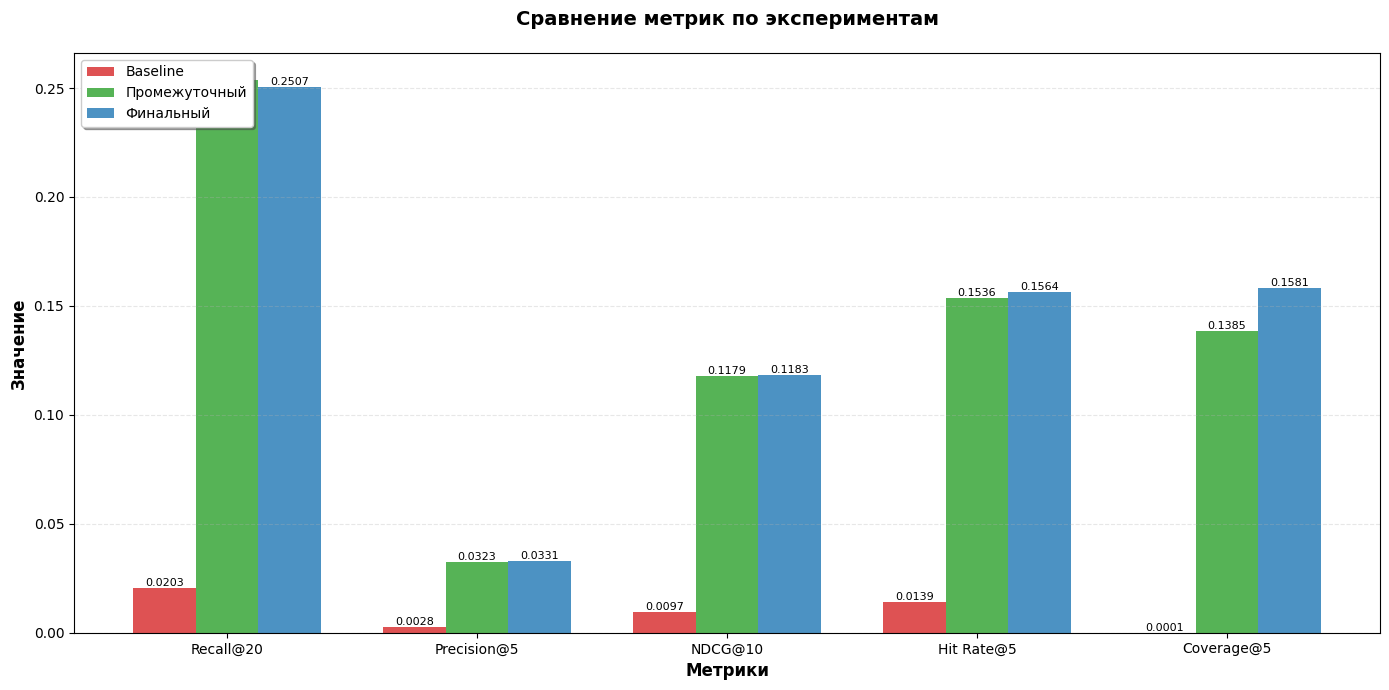

In [9]:
import matplotlib.pyplot as plt

# Подготовка данных для графика
baseline_coverage = baseline_metrics.get('coverage@5', 0.0)
intermediate_coverage = intermediate_metrics.get('coverage@k', intermediate_metrics.get('coverage@5', 0.0))
final_coverage = final_metrics.get('coverage@k', final_metrics.get('coverage@5', 0.0))

metrics_names = ['Recall@20', 'Precision@5', 'NDCG@10', 'Hit Rate@5', 'Coverage@5']
baseline_values = [
    baseline_metrics['recall@20'],
    baseline_metrics['precision@5'],
    baseline_metrics['ndcg@10'],
    baseline_metrics['hit_rate@5'],
    baseline_coverage,
]
intermediate_values = [
    intermediate_metrics['recall@20'],
    intermediate_metrics['precision@5'],
    intermediate_metrics['ndcg@10'],
    intermediate_metrics['hit_rate@5'],
    intermediate_coverage,
]
final_values = [
    final_metrics['recall@20'],
    final_metrics['precision@5'],
    final_metrics['ndcg@10'],
    final_metrics['hit_rate@5'],
    final_coverage,
]

# Создание графика
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(metrics_names))
width = 0.25

bars1 = ax.bar(x - width, baseline_values, width, label='Baseline', color='#d62728', alpha=0.8)
bars2 = ax.bar(x, intermediate_values, width, label='Промежуточный', color='#2ca02c', alpha=0.8)
bars3 = ax.bar(x + width, final_values, width, label='Финальный', color='#1f77b4', alpha=0.8)

# Добавление значений на столбцы
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=8)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

ax.set_xlabel('Метрики', fontsize=12, fontweight='bold')
ax.set_ylabel('Значение', fontsize=12, fontweight='bold')
ax.set_title('Сравнение метрик по экспериментам', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, rotation=0, ha='center')
ax.legend(loc='upper left', frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

## Выводы и рекомендации

## Эксперимент 3, ALS с весами + Content-Based Re-ranking показал:

1. Максимальный Recall@20 - основная метрика
2. Улучшение всех метрик vs промежуточного варианта
3. Гибридный подход (collaborative + content-based)
4. Значительное улучшение vs Baseline
Параметры для продакшена:
- Веса: view=1.0, addtocart=4.0, transaction=8.0
- ALS: factors=256, alpha=4.0, reg=0.1, iter=25
- Re-ranking: alpha=0.6, beta=0.4, adaptive=True

СОЗДАННЫЕ АРТЕФАКТЫ:
1. Модель (bin-файл): /home/mle-user/mle-pr-final/artifacts/model/als_model.pkl
2. Metadata: /home/mle-user/mle-pr-final/artifacts/model/metadata.json
3. User-Item Matrix: /home/mle-user/mle-pr-final/artifacts/model/user_item_matrix.npz
4. Popular Items: /home/mle-user/mle-pr-final/artifacts/model/popular.json
5. Лог файл: /home/mle-user/mle-pr-final/logs/experiments_processing_2025-12-19_21-44-11.log

ПАЙПЛАЙН ОБРАБОТКИ ДАННЫХ И ПОСТРОЕНИЯ МОДЕЛИ:
1. Загрузка данных (events, metadata)
2. Построение interactions с весами событий
3. Temporal split на train/test
4. Построение user-item матрицы
5. Обучение ALS модели
6. Генерация рекомендаций с fallback
7. Content-Based Re-ranking
8. Оценка метрик
9. Сохранение модели в bin-файл